#**Traffic Sign Classification with CNN**

#### Mariana De la Vega Martínez || Fernando Esaúl Franco Robles || Tomás David Medina Romero

Using the German Dataset for traffic sign classification (http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset), we will train our convolutional neural network in order to classify our own traffic sign images.

In [ ]:
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline

###1. Loading the data

Using pickle we will load the German Dataset, dividing it in three sections: training, validation and testing. The *pickle* files can be found in the following folder: https://drive.google.com/drive/folders/1OxvstebcaWlcGibG5xnbRMlwt2O1mGqf?usp=sharing

In [ ]:
# Change desired path
main_path = '/content/drive/My Drive/Deep Learning/Project/data'

train_path = main_path + "/train.p"
val_path = main_path + "/val.p"
test_path = main_path + "/test.p"

with open(train_path, mode='rb') as f:
    train = pickle.load(f)
with open(val_path, mode='rb') as f:
    val = pickle.load(f)
with open(test_path, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_val, y_val = val['features'], val['labels']
X_test, y_test = test['features'], test['labels']

The data we got from pickle is a dictionary with 4 keys:

*   `'features'`: raw pixel data in 4D array (num examples, width, height, channels)
*   `'labels'`: label id of the sign in a 2D array
  *   Here we use the file `signnames.csv` which contains the id-name mapping
*   `'sizes'`: list of tuples (width, height) for the original image
*   `'coords'`: list of tuples (x1, y1, x2, y2) for the bounding box around the sign in the image. 

In [ ]:
num_train = len(X_train)
num_val = len(X_val)
num_test = len(X_test)

img_shape = X_train[0].shape

# Labels in dataset
num_classes = len(set(y_train))

print("Number of training images =", num_train)
print("Number of validation images =", num_val)
print("Number of testing images =", num_test)
print("Image shape =", img_shape)
print("Number of classes =", num_classes)

Number of training images = 34799
Number of validation images = 4410
Number of testing images = 12630
Image shape = (32, 32, 3)
Number of classes = 43


####1.1 Viewing the data

To measure the balance of classes, we plot the number of images per class and in order to view the data, we show one image for each of the 43 classes from the German Dataset.

In [ ]:
def show_images(clahe=None, dataset=None):
  plt.figure(figsize=(16, 16))
  for c in range(num_classes):
    i = random.choice(np.where(y_train == c)[0])    # choose a random image of the class c
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    if dataset is not None: 
      plt.imshow(dataset.features[i].squeeze(), cmap='gray')      # if it comes from the dataset, we need to extract the features
    elif clahe is None: plt.imshow(X_train[i])
    else: plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [ ]:
def show_balance_class(dataset, lbl=False):
  fig, ax = plt.subplots()
  if lbl: ax.bar(range(num_classes), np.bincount(dataset.labels), 0.5, color='g')     # np.bincount allow us to automatically count how many images per class
  else: ax.bar(range(num_classes), np.bincount(dataset), 0.5, color='g')
  ax.set_xlabel('Class')
  ax.set_ylabel('Number of images')
  ax.set_title('Images per class')
  plt.show()

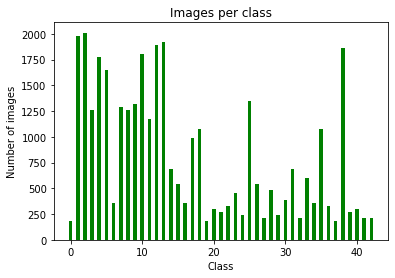

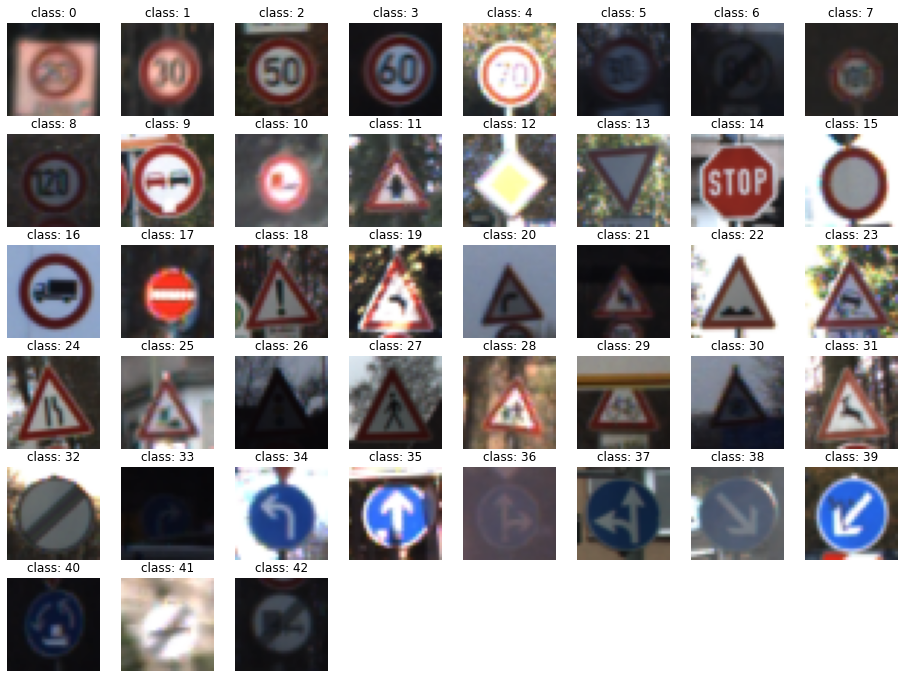

In [ ]:
show_balance_class(y_train)
show_images()

####1.2 Dataset & Dataloader

For our dataset, we use the *pickle* file to extract the dictionary mentioned above and we apply the desired transformations. When we get an item from the dataset we will return the features (image) and the class label.

In [ ]:
class TrafficSignDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            # get data from pickle dictionary
            self.features = data['features'] 
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            # data augmentation
            feature = self.transform(feature) 
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

For our dataloader, the only new thing is that we included the function to pass the image to the GPU inside this class. This allow us to avoid the `to.(device)` step during training and testing.

In [ ]:
class TrafficSignDataLoader:
  def __init__(self, dl, func):
    # func --> in order to use GPU
    self.dl = dl
    self.func = func

  def __len__(self):
    return len(self.dl)

  def __iter__(self):
    batches = iter(self.dl)
    for b in batches:
        yield (self.func(*b))

###2. Data preprocessing

The German Dataset has 2 issues:

*   Class imbalance: some classes have more samples than others. (As shown in the graph above)
*   Contrast variation: the images differ in contrast and brightness (they are even difficult to classify for a human)

So in order to fix this we will work with some data augmentation.


####2.1 High contrast variation (CLAHE)
We will use a grayscale because there haven't been any improvements using RGB. We will do the preprocessing and save the 'new' images to improve efficiency (the other way will have to preprocess every image during training).

CLAHE stands for *Contrast Limited Adaptive Histogram Equalization* and it will help us to change our images to one channel only and also to improve the contrast on the images.

In [ ]:
class CLAHE_GRAY:
  def __init__(self, clipLimit=2.5, tileGridSize=(4, 4), transform=False):
    self.clipLimit = clipLimit
    self.tileGridSize = tileGridSize
    self.transform = transform

  def __call__(self, im):
    #print('clahe im', im.shape)
    if self.transform: im = np.array(im)
    img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
    clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
    img_y = clahe.apply(img_y)
    img_output = img_y.reshape(img_y.shape + (1,))
    return img_output

Let's see the dataset images after applying the CLAHE:

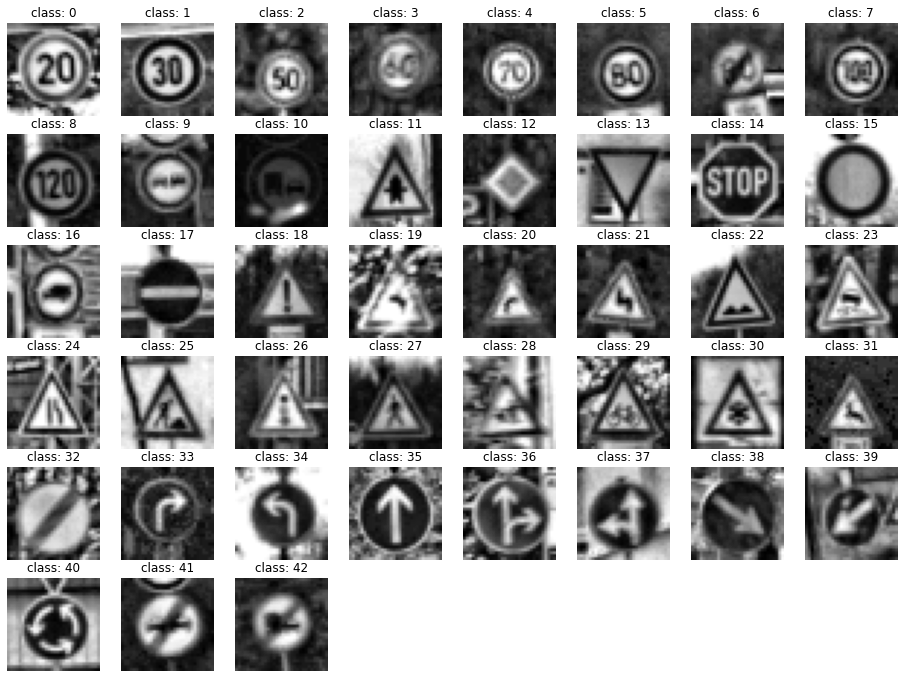

In [ ]:
clahe = CLAHE_GRAY()
show_images(clahe=clahe)

####2.2 Data transformation

Applying the CLAHE modification:

In [ ]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

This function will be useful in further steps for the final model.

In [ ]:
def preprocess(path):
  if not os.path.exists(f"{path}/train_gray.p"):
    for dataset in ['train', 'val', 'test']:
      with open(f"{path}/{dataset}.p", mode='rb') as f:
        data = pickle.load(f)
        X = data['features']
        y = data['labels']

      clahe = CLAHE_GRAY()
      for i in range(len(X)):
        print('clahe ', i)
        X[i] = clahe(X[i])

      X = X[:, :, :, 0]
      with open(f"{path}/{dataset}_gray.p", "wb") as f:
        pickle.dump({"features": X.reshape(X.shape + (1,)), "labels": y}, f)

###3. Model

We will implement a model with

*   2 Convs --> (input_channels, 6) & (6, 16)
  *    Using a kernel of 5 in order to learn more features
*   MaxPool --> divide the dimensions in 2
*   3 FC 
*  ReLU as activation layers

In [ ]:
class TrafficSignNet(nn.Module):
  def __init__(self, gray=False):
    super(TrafficSignNet, self).__init__()
    input_channel = 1 if gray else 3
    self.convs = nn.Sequential(
        nn.Conv2d(input_channel, 6, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(6, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
    )
    self.fcs = nn.Sequential(
        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 43)
    )

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, 16 * 5 * 5)
    x = self.fcs(x)
    return x

###4. Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_dataset = TrafficSignDataset(train_path, transform=data_transforms)
val_dataset = TrafficSignDataset(val_path, transform=data_transforms)
test_dataset = TrafficSignDataset(test_path, transform=data_transforms)

train_dataloader = TrafficSignDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
val_dataloader = TrafficSignDataLoader(DataLoader(val_dataset, batch_size=64, shuffle=False), to_device)
test_dataloader = TrafficSignDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

We decided to use a `CrossEntropyLoss` for the criterion and an `SGD` for the optimizer with `momentum = 0.9`. For this specific implementation of the model, we chose a learning rate of `1e-3`. It is also important to mention that the model trains really fast so only `20 epochs` were necessary.

In [ ]:
# Hyper parameters
lr = 0.001
epochs = 20

model = TrafficSignNet(gray=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

####4.1 Loss

In order to avoid a for loop in the training function and facilitate the overall loss calculation, we will write a loss function that will help get the loss from the entire dataloader.

In [ ]:
def loss_for_training_batch(model, criterion, data, labels, optimizer=None):
  # data --> all images from batch
  # labels --> ground truth for each image
  loss = criterion(model(data), labels)

  # only when is training
  if optimizer is not None:
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # also return the number of images in batch to further calculate overall loss
  return loss.item(), len(data)

In [ ]:
def loss_for_validation_batch(model, criterion, data, labels):
  output = model(data)
  loss = criterion(model(data), labels)
  # Use 'max' in order to get the actual prediction of the model
  preds = torch.argmax(output, dim=1)
  # Check how many predictions were correct in order to further calculate accuracy
  correct = preds == labels.view(*preds.shape)

  return loss.item(), torch.sum(correct).item(), len(data)

####4.2 Train & Test

In [ ]:
def train(epochs, model, criterion, optimizer, train_dataloader, val_dataloader):
    for epoch in range(epochs):
        # Set model in training mode
        model.train()
        losses, total = zip(*[loss_for_training_batch(model, criterion, data, labels, optimizer) for data, labels in train_dataloader])
        train_loss = np.sum(np.multiply(losses, total)) / np.sum(total)       # get overall loss --> average
        # Set model in evaluation mode
        model.eval()
        with torch.no_grad():
            losses, corrects, total = zip(*[loss_for_validation_batch(model, criterion, data, labels) for data, labels in val_dataloader])
            val_loss = np.sum(np.multiply(losses, total)) / np.sum(total)     # get average loss
            val_acc = np.sum(corrects) / np.sum(total) * 100                  # efficiency percentage
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Training loss: {train_loss:.6f}\t"
                  f"Validation loss: {val_loss:.6f}\t",
                  f"Validation accuracy: {val_acc:.2f}%")

In [ ]:
def test(model, criterion, dataloader):
    # Set model in evaluation mode
    model.eval()
    with torch.no_grad():
        losses, corrects, total = zip(*[loss_for_validation_batch(model, criterion, data, labels) for data, labels in dataloader])
        test_loss = np.sum(np.multiply(losses, total)) / np.sum(total)
        test_acc = np.sum(corrects) / np.sum(total) * 100
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accuracy: {test_acc:.2f}%")

In [ ]:
train(epochs, model, criterion, optimizer, train_dataloader, val_dataloader)
test(model, criterion, test_dataloader)

[Epoch 1/20] Training loss: 3.619950	Validation loss: 3.560181	 Validation accuracy: 6.62%
[Epoch 2/20] Training loss: 3.467267	Validation loss: 3.547430	 Validation accuracy: 6.05%
[Epoch 3/20] Training loss: 3.428395	Validation loss: 3.458377	 Validation accuracy: 13.56%
[Epoch 4/20] Training loss: 2.979869	Validation loss: 2.448726	 Validation accuracy: 35.40%
[Epoch 5/20] Training loss: 1.753617	Validation loss: 1.419274	 Validation accuracy: 60.52%
[Epoch 6/20] Training loss: 1.083885	Validation loss: 0.936763	 Validation accuracy: 73.61%
[Epoch 7/20] Training loss: 0.764866	Validation loss: 0.818386	 Validation accuracy: 75.15%
[Epoch 8/20] Training loss: 0.592780	Validation loss: 0.646950	 Validation accuracy: 79.89%
[Epoch 9/20] Training loss: 0.485808	Validation loss: 0.594254	 Validation accuracy: 82.61%
[Epoch 10/20] Training loss: 0.413908	Validation loss: 0.523385	 Validation accuracy: 85.03%
[Epoch 11/20] Training loss: 0.363566	Validation loss: 0.475056	 Validation accur

###5. Modifications

####5.1 Fixing imbalance of classes

#####5.1.1 Flipping

Since we are working with images of traffic sign, we can modify the images in certain ways causing them to belong to a new class. For example, if we have a 'turn right' image and we flip it, we will now have a 'turn left' image. 

In [ ]:
def flip_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_flip = np.empty([0] + list(X.shape)[1:], dtype=X.dtype)
    y_flip = np.empty([0], dtype = y.dtype)
    
    # We already identified which images to flip in order to make them belong to a different class
    horizontal_flip_images = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertical_flip_images = [1, 5, 12, 15, 17]
    both_flip_images = [32, 40]
    cross_flip_images = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
      X_flip = np.append(X_flip, X[y==c], axis=0)       # we add the images belonging to class c
      # We check in which way we can flip them, prioritizing horizontal and vertical flips before the cross flip and the ones that can do both
      if c in horizontal_flip_images:
        X_flip = np.append(X_flip, X[y==c][:,:,::-1,:], axis=0)
      if c in vertical_flip_images:
        X_flip = np.append(X_flip, X[y==c][:,::-1,:,:], axis=0)
      if c in cross_flip_images[:,0]:
        cross_flip = cross_flip_images[cross_flip_images[:,0]==c][0][1]
        X_flip = np.append(X_flip, X[y==cross_flip][:,:,::-1,:], axis=0)
      if c in both_flip_images:
        X_flip = np.append(X_flip, X[y==c][:,::-1,::-1,:], axis=0)
      
      y_flip = np.append(y_flip, np.full(X_flip.shape[0]-y_flip.shape[0], c, dtype=y_flip.dtype))
    
    dataset.features = X_flip
    dataset.labels = y_flip
    dataset.count = len(y_flip)

    return dataset

In the function above we extended the dataset because we added the images belonging to the classes plus the 'new' images we just flipped in different directions.

In [ ]:
train_dataset = flip_dataset(train_dataset)
train_dataloader = TrafficSignDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)

Now we can visualize the updated balance of classes:

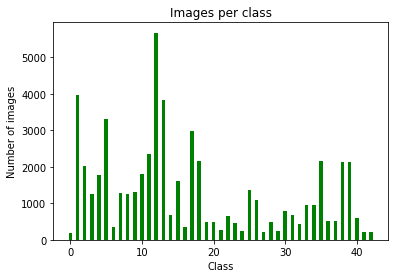

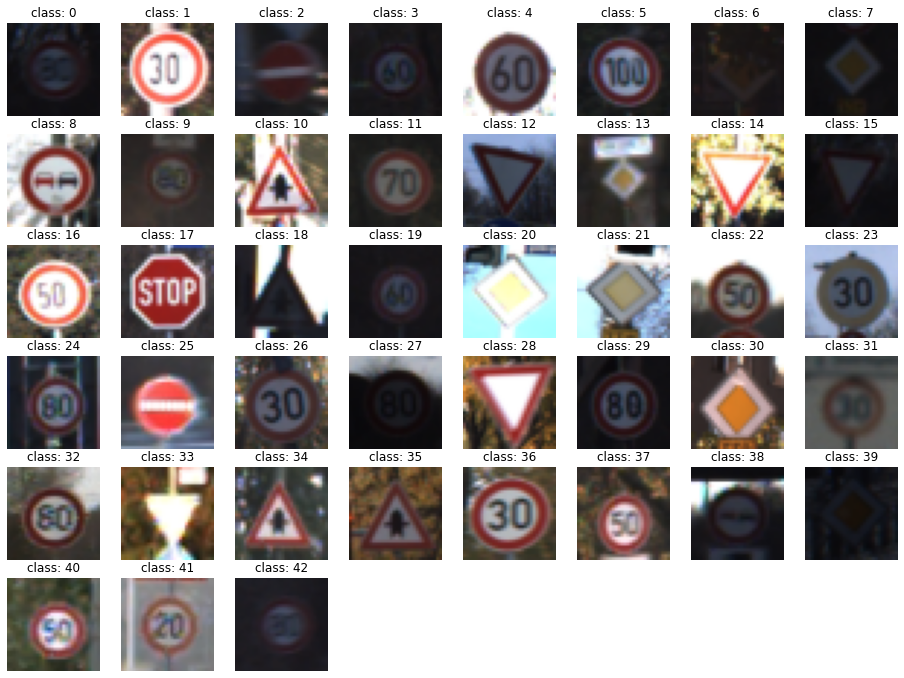

In [ ]:
show_balance_class(train_dataset, lbl=True)
show_images(dataset=train_dataset)

If we compare the previous chart we had with the new one:

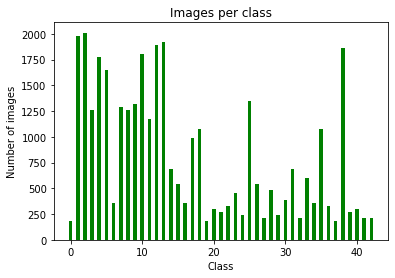

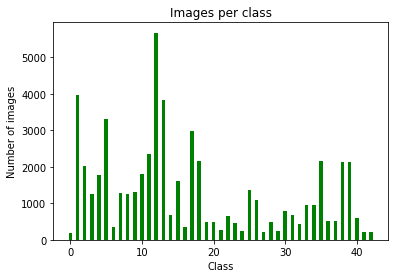

In [ ]:
# Before
show_balance_class(y_train)

# After flip
show_balance_class(train_dataset, lbl=True)

There is still some imbalance (since we only modify one aspect of the image) but we can already see some improvement.

If we try the model with the 'new' dataset, we will see that the test accuracy improves slightly.

In [ ]:
model = TrafficSignNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(epochs, model, criterion, optimizer, train_dataloader, val_dataloader)
test(model, criterion, test_dataloader)

[Epoch 1/20] Training loss: 3.107262	Validation loss: 3.316838	 Validation accuracy: 19.52%
[Epoch 2/20] Training loss: 1.250393	Validation loss: 1.176681	 Validation accuracy: 65.40%
[Epoch 3/20] Training loss: 0.540479	Validation loss: 0.788246	 Validation accuracy: 77.17%
[Epoch 4/20] Training loss: 0.349502	Validation loss: 0.652891	 Validation accuracy: 81.16%
[Epoch 5/20] Training loss: 0.251229	Validation loss: 0.520525	 Validation accuracy: 85.24%
[Epoch 6/20] Training loss: 0.193611	Validation loss: 0.476100	 Validation accuracy: 87.03%
[Epoch 7/20] Training loss: 0.155322	Validation loss: 0.423229	 Validation accuracy: 88.62%
[Epoch 8/20] Training loss: 0.127231	Validation loss: 0.380598	 Validation accuracy: 90.23%
[Epoch 9/20] Training loss: 0.107633	Validation loss: 0.376545	 Validation accuracy: 90.11%
[Epoch 10/20] Training loss: 0.090033	Validation loss: 0.324401	 Validation accuracy: 91.52%
[Epoch 11/20] Training loss: 0.077627	Validation loss: 0.325606	 Validation acc

####5.2 Data Augmentation

#####5.2.1 Weighted Random Sampler

This class, given by the pytorch libraries, samples all of the classes (43 in this case) with equal amount and passed that to data loader of PyTorch. This specific sampler samples elements with given probabilities (weights). Using this sampler, we are now able to have the same amount of images for each class, as shown in the blue graph below.

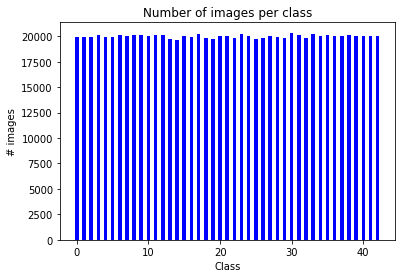

In [ ]:
train_dataset = flip_dataset(TrafficSignDataset(train_path))
class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
sampler = sampler.WeightedRandomSampler(weights, 43 * 20000)

train_dataloader = TrafficSignDataLoader(DataLoader(train_dataset, batch_size=64, sampler=sampler), to_device)

balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_dataloader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(num_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='b')
ax.set_xlabel('Class')
ax.set_ylabel('# images')
ax.set_title('Number of images per class')
plt.show()

#####5.2.2 Further transformations

Now we geometrically transform the data with some
*   Rotation
*   Translation
*   Shear mapping 
*   Scaling

This is easily done with the torchvision transforms library. These said transformations are only for the training data.

In [ ]:
train_data_transforms = transforms.Compose([                                             
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()                                        
])

test_data_transforms = transforms.Compose([          
    transforms.ToTensor()
])

####5.3 Preprocessing

We are now going to use the *`preprocess`* function in order to create the gray images before training. The function saves the new images in a different path and we will pass said path to the dataloaders.

Now we implement all of the data preprocessing, augmentation and transformation for the final datasets and dataloaders.

In [ ]:
preprocess(main_path)

train_path = main_path + '/train_gray.p'
val_path = main_path + "/val_gray.p"
test_path = main_path + "/test_gray.p"

In [ ]:
train_dataset = flip_dataset(TrafficSignDataset(train_path, transform=train_data_transforms))
val_dataset = TrafficSignDataset(val_path, transform=test_data_transforms)
test_dataset = TrafficSignDataset(test_path, transform=test_data_transforms)

# We only use the sampler in the training dataloader
train_dataloader = TrafficSignDataLoader(DataLoader(train_dataset, batch_size=64, sampler=sampler), to_device)
val_dataloader = TrafficSignDataLoader(DataLoader(val_dataset, batch_size=64, shuffle=False), to_device)
test_dataloader = TrafficSignDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

Here we can visualize all the transformations done to the images of each class.

In [ ]:
def convert_image_to_numpy(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()      # correct the channel's position
    return img

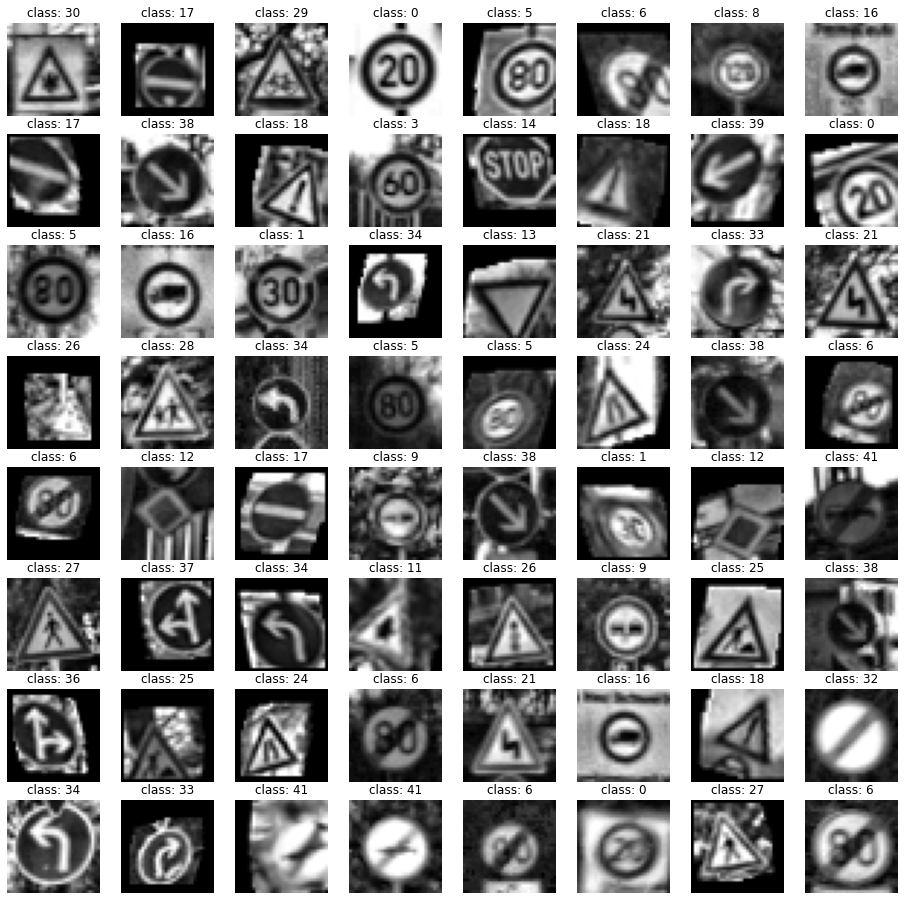

In [ ]:
with torch.no_grad():
  data, labels = next(iter(train_dataloader))        # get batch's info
  plt.figure(figsize=(16, 16))
  for i in range(len(labels)):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    plt.title('class: {}'.format(labels[i]))
    plt.imshow(convert_image_to_numpy(data[i].cpu()), cmap='gray')

Let's train the model again with these new data augmentation to compare with the previous results.

In [ ]:
model = TrafficSignNet(gray=True).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
train(epochs, model, criterion, optimizer, train_dataloader, val_dataloader)
test(model, criterion, test_dataloader)

[Epoch 1/20] Training loss: 2.724984	Validation loss: 0.614541	 Validation accuracy: 82.04%
[Epoch 2/20] Training loss: 0.838525	Validation loss: 0.353694	 Validation accuracy: 89.64%
[Epoch 3/20] Training loss: 0.535171	Validation loss: 0.298592	 Validation accuracy: 90.75%
[Epoch 4/20] Training loss: 0.417447	Validation loss: 0.251515	 Validation accuracy: 92.36%
[Epoch 5/20] Training loss: 0.350581	Validation loss: 0.227858	 Validation accuracy: 93.51%
[Epoch 6/20] Training loss: 0.307263	Validation loss: 0.308529	 Validation accuracy: 91.63%
[Epoch 7/20] Training loss: 0.272937	Validation loss: 0.216445	 Validation accuracy: 94.51%
[Epoch 8/20] Training loss: 0.248177	Validation loss: 0.242733	 Validation accuracy: 94.35%
[Epoch 9/20] Training loss: 0.228608	Validation loss: 0.180627	 Validation accuracy: 95.08%
[Epoch 10/20] Training loss: 0.214169	Validation loss: 0.220581	 Validation accuracy: 94.65%
[Epoch 11/20] Training loss: 0.200359	Validation loss: 0.188748	 Validation acc

Here we can easily see how the flipping and the weighted sampling improved our accuracy.

####5.4 Improving the network

We will implement additional conv layers besides the regularization and remove one FC layer.

#####5.4.1 Regularization

We will implement three types of regularization in order to improve the model. 

1.   **Dropout**: prevent overfitting. Used in the FC and CNN layers.
2.   **Batch Normalization**: used in the CNN layers (2d) and in the FC layers (1d).
3.   **Early Stopping**: train the dataset until the validation accuracy starts to degrade. We will use a max of 100 epochs in which if the loss has not improved after 10 epochs, we will stop the training. For this we will keep track of each epoch's loss.

In [ ]:
class TrafficSignNet(nn.Module):
  def __init__(self, gray=False):
    super(TrafficSignNet, self).__init__()

    self.convs = nn.Sequential(
        nn.Conv2d(1, 100, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(100),
        nn.Dropout(p=0.5),
        nn.Conv2d(100, 150, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(150),
        nn.Dropout(p=0.5),
        nn.Conv2d(150, 250, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.BatchNorm2d(250),
        nn.Dropout(p=0.5),

    )
    self.fcs = nn.Sequential(
        nn.Linear(250 * 3 * 3, 350),
        nn.ReLU(),
        nn.BatchNorm1d(350),
        nn.Dropout(p=0.5),
        nn.Linear(350, 43)
    )

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, 250 * 3 * 3)
    x = self.fcs(x)
    return x

Now in order to keep track of the epoch's loss, we will modify the `train` function.

In [ ]:
# Modify the path to where you want to save your trained model

save_path = '/content/drive/My Drive/Deep Learning/Project/results/improvedTrafficSignNet.pt'

In [ ]:
def train(epochs, model, criterion, optimizer, train_dataloader, val_dataloader, patience=10):
    wait = 0
    val_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, total = zip(*[loss_for_training_batch(model, criterion, data, labels, optimizer) for data, labels in train_dataloader])
        train_loss = np.sum(np.multiply(losses, total)) / np.sum(total)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, total = zip(*[loss_for_validation_batch(model, criterion, data, labels) for data, labels in val_dataloader])
            val_loss = np.sum(np.multiply(losses, total)) / np.sum(total)
            val_accuracy = np.sum(corrects) / np.sum(total) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {val_loss:.6f}\t",
                  f"Validation accuracy: {val_accuracy:.2f}%")
            # Save model if validation loss has decreased
            if val_loss <= val_loss_min:
                print(f"Validation loss decreased ({val_loss_min:.6f} --> {val_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), save_path)
                val_loss_min = val_loss
                wait = 0
            # Validate for early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Patience of {patience} reached at epoch {epoch+1} ... Early stopping")
                    return

Since we improved our model, we confirmed that a smaller learning rate was necessary and we used `1e-4`. We also increased to a `100 epochs`as explained above. The criterion and optimizer did not change.

Let's see if the new model has better results.

In [ ]:
epochs = 100
lr = 0.0001
model = TrafficSignNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
train(epochs, model, criterion, optimizer, train_dataloader, val_dataloader)

[Epoch 1/100] Train loss: 1.099729	Validation loss: 0.164452	 Validation accruacy: 96.395%
Validation loss decreased (inf --> 0.164452). Saving model...
[Epoch 2/100] Train loss: 0.410502	Validation loss: 0.111028	 Validation accruacy: 97.755%
Validation loss decreased (0.164452 --> 0.111028). Saving model...
[Epoch 3/100] Train loss: 0.277119	Validation loss: 0.088169	 Validation accruacy: 98.231%
Validation loss decreased (0.111028 --> 0.088169). Saving model...
[Epoch 4/100] Train loss: 0.218554	Validation loss: 0.078189	 Validation accruacy: 98.345%
Validation loss decreased (0.088169 --> 0.078189). Saving model...
[Epoch 5/100] Train loss: 0.188201	Validation loss: 0.087184	 Validation accruacy: 98.277%
[Epoch 6/100] Train loss: 0.167381	Validation loss: 0.077765	 Validation accruacy: 98.526%
Validation loss decreased (0.078189 --> 0.077765). Saving model...
[Epoch 7/100] Train loss: 0.153277	Validation loss: 0.087585	 Validation accruacy: 98.549%
[Epoch 8/100] Train loss: 0.14212

###6. Testing the model

Now that we have actually implemented the function to save our best trained model, we can easily use that file in order to test our model any time we want. This file is the one that will be used in our website to test it with our own images.

Our trained model file *improvedTrafficSignNet.pt* is in the following folder: https://drive.google.com/drive/folders/1-2xgickRATZOKFa_u0ovAm3k2St63gdL?usp=sharing 

In [ ]:
# Load your own file for the pretrained model or use ours with the link above

check_point = torch.load('/content/drive/My Drive/Deep Learning/Project/results/improvedTrafficSignNet.pt', map_location=device)
model.load_state_dict(check_point)
test(model, criterion, test_dataloader)

Test loss: 0.042324	Test accuracy: 98.71%


###7. Results

To summarize:

We trained our model 4 different times:
1. Using our 2-convs, 3-fc model with the German Dataset only modified with a monochromatic CLAHE.
2. The model used in (1) plus the monochromatic CLAHE extended dataset (using the `flip` function).
3. Based on (2) we added a sampler and further transformations (Section 5.2.2) to our dataset.
4. The improved model with 3-convs and 2-fc including regularization.


The following graphs allow us to visualize how each training was better than the previous one and help us emphasize on how important data augmentation and network regularization are.

In [ ]:
def compare_models(data, y_axis_lbl, x_axis_lbl, models_names, title):
  y_pos = np.arange(len(models_names))
  plt.bar(y_pos, data, align='center', alpha=0.5)
  plt.xticks(y_pos, models_names)
  plt.ylabel(y_axis_lbl)
  plt.xlabel(x_axis_lbl)
  plt.title(title)

  plt.show()

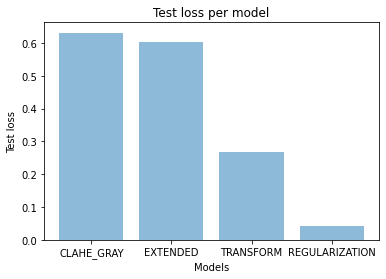

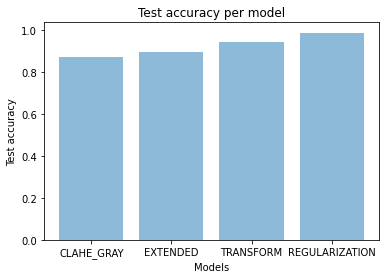

In [ ]:
test_loss = [0.630822, 0.603922, 0.268479, 0.042324]
test_acc = [0.8740, 0.8941, 0.9425, 0.9871]
y_axis_lbl = ['Test loss', 'Test accuracy']
x_axis_lbl = 'Models'
title = ['Test loss per model', 'Test accuracy per model']
models_names = ['CLAHE_GRAY', 'EXTENDED', 'TRANSFORM', 'REGULARIZATION']

compare_models(test_loss, y_axis_lbl[0], x_axis_lbl, models_names, title[0]) 
compare_models(test_acc, y_axis_lbl[1], x_axis_lbl, models_names, title[1]) 

###8. Web Application

Our project is based on Starlette and we follow this link https://medium.com/analytics-vidhya/reading-turning-your-deep-learning-model-into-a-web-app-35f67efcc456 in order to use our pretrained model to test our own images.
- We need to import our trained model (.pt file created two cells above). For this we just need to have the path to said file in our server.

By following the tutorial mentioned above we were able to mount a website in a localhost. For it to work, we needed to copy our `TrafficSignNet` model and our `test` function (which was modified) and we had to create a one-image dataset and apply the required transformations for the image to work on our model.

The dataset we implemented for a one-image dataloader is the following:

In [ ]:
class MyDataset(IterableDataset):
    def __init__(self, image_queue, transform=None):
      self.queue = image_queue
      self.transform = transform

    def read_next_image(self):
        while self.queue.qsize() > 0:
            yield self.queue.get()
        return None

    def __iter__(self):
        return self.read_next_image()

As said before, our `test` function was modified. The following changes were made:
*   We got rid of the loss, because we do not need to calculate the accuracy anymore, we just want to get the predictions.
*   Instead of getting the maximum prediction score, we saved the top 3. We decided this because since our model does not reach the 100% accuracy there's still a probability that some clasiffication is wrong, but having the top 3 scores we can analyze if the second best prediction is the correct one and how far both scores are from each other. This was incredibly helpful when we test our own dataset (next section).

In [ ]:
def get_top_predictions(model, data):
  output = model(data)
  # Apply softmax to get class probability
  softmax = nn.Softmax(dim=1)
  output = softmax(output)
  preds_top = torch.topk(output, k=3, dim=1)

  return preds_top

The function we implemented in the template website helps with:
*   Changes the image's channels to 1 in order to fit the model.
*   Resizes the image to the 32x32 dimensions the German Dataset asks for.
*   Loads the already trained model using the .pt file.
*   Maps the predicted classes with the actual names and shows it in screen.

In [ ]:
def predict_from_bytes(bytes):
    # Open image
    buffer = queue.Queue()
    img = Image.open(io.BytesIO(bytes))
    img = np.array(img)
    # From 3 to 1 channel
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = cv2.resize(img, (32, 32))
    img = TF.to_tensor(img)
    img = img.view(-1,32,32)
    buffer.put(img)
    # Create dataset
    dataset = MyDataset(buffer)
    # Instantiate model
    model = TrafficSignNet()
    # Load model
    check_point = torch.load('/Users/marianadelavega/Downloads/improvedTrafficSignNet.pt', map_location=torch.device('cpu'))
    model.load_state_dict(check_point)
    # Create dataloader with only one image
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
    # Get top 3 predictions
    predictions = test(model, dataloader)

    result_html1 = path / 'static' / 'result1.html'
    result_html2 = path / 'static' / 'result2.html'

    # Map predictions with classes

    result = ''

    for (scores, label) in predictions:
        for i in range(3):
            result += str(i+1) + '. ' + str(classes[label[0][i]]) + ' | Score: ' + str(scores[0][i])[7:-1] + '<br>'

    # Show top 3 results in html

    result_html = str(result_html1.open().read() + result + result_html2.open().read())
    return HTMLResponse(result_html)

####8.1 Results

There are 12,000+ images for testing and all of the tests we did were correct and the majority of them had a 100% probability score for the predicted class. You can look at some of our results in the following folder: https://drive.google.com/drive/folders/11bN2IclCx3EKU1eYILUoLiaqkUwzsfTW?usp=sharing

###9. Own Dataset

In [ ]:
from PIL import Image
import cv2

In [ ]:
def get_own_images(num_imgs, imgs_dim, path):
  imgs = []
  for i in range(num_imgs):
    img = Image.open(path+str(i+1)+'.png')
    img = np.asarray(img)
    img = cv2.resize(img, imgs_dim)
    imgs.append(img)

  return np.asarray(imgs)

In [ ]:
def show_own_images(num_imgs, imgs_dim, path):
  data = get_own_images(num_imgs, imgs_dim, path)       # get images
  plt.figure(figsize=imgs_dim)
  for i in range(num_imgs):
    plt.subplot(2, num_imgs/2+num_imgs%2, i+1)
    plt.axis('off')
    plt.imshow(data[i])

As part of the project we decided to go out and take pictures of some Mexican traffic signs. Here we can visualize some of the pictures.

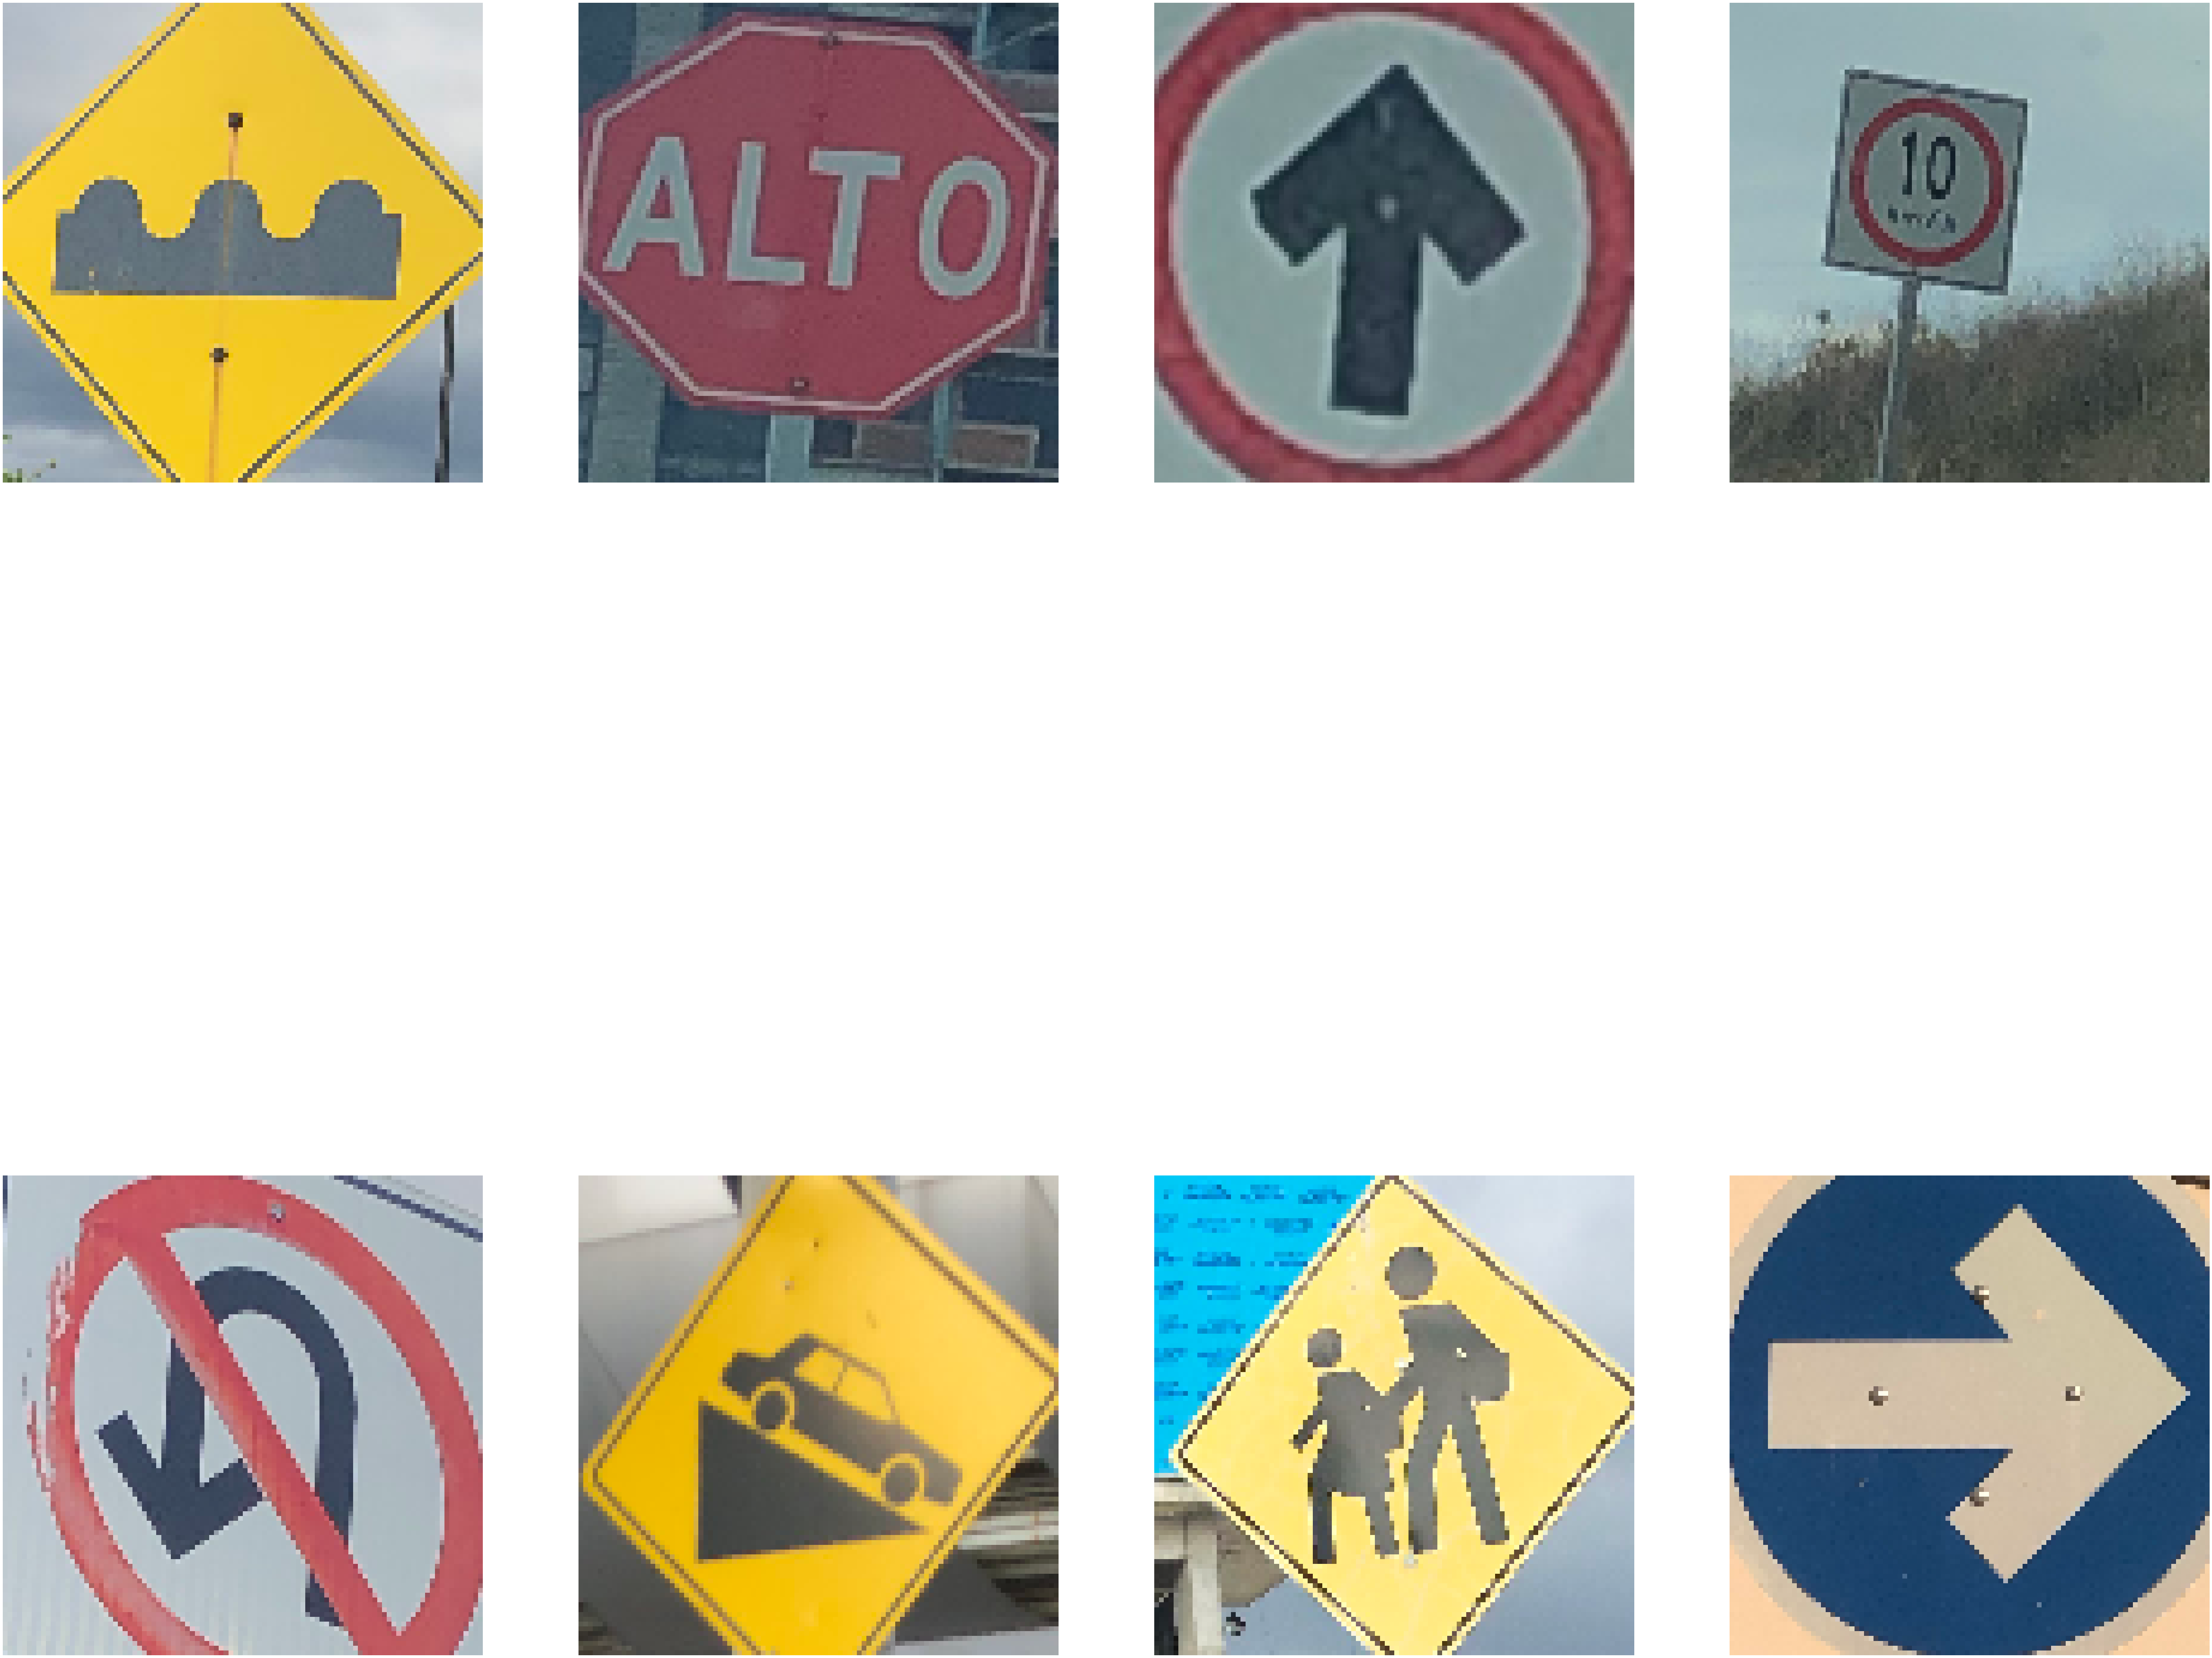

In [ ]:
show_own_images(8, (100,100), '/content/drive/My Drive/Deep Learning/Project/images_mx/Images_mx_Recortadas/')

Our test results were not favorable for our own datasets. With this we mean that our model was not able to correctly classify any of our images, except for one. In some cases the second and third score had a class similarity to the ground truth, but in general the results were not as expected.

After some analysis, we came up with the following conclusions:
- The shapes from the German Dataset in some classes differ from those in our dataset for the same classes.
- Also the color changes, for our dataset some class will be red and for the German Dataset that same class would be blue. Even though we are using only one channel, the pixel values are still affected by these changes.
- We were not able to document a fair amount of pictures and the ones we got are only of about 5 classes of the German Dataset. This is because most of the classes in said dataset are used in highways and we were not able to travel to get that kind of data.

####9.1 Improvements

The first part of the project really demonstrate how using a pretrained model and applying transfer learning is way more efficient than training a model with a dataset in order to use it for a completely different one. So we decided to improve our dataset by:

* Increasing the number of images per class (about 80)
* Increasing the number of classes

#####9.1.1 Transfer Learning

Since the trained model for the German Dataset did not properly work with our own dataset, we decided to apply transfer learning. For this we will use the `fastai` library and a pretrained resnet model. 

In [ ]:
from fastai.vision import *
import warnings
warnings.filterwarnings('ignore')
from fastai.imports import *

For our new dataset we ended up with **304 total images** divided in **7 classes**. Because of the time we decided to have less classes but a fair amount of images for each of them. Using `fastai` we created a `DataBunch` from our drive folder https://drive.google.com/drive/folders/1MmdJdAxIqMJXB5C4tLLxyeLNXeXFKqpi?usp=sharing.

We used 80% of those 300+ images for training and the other 20% for validation (we created our own test dataset). In the output below we can see the number of classes and its names, as well as the train and validation dataset specifications.

In [ ]:
path = '/content/drive/My Drive/Deep Learning/Project/mx_dataset_final/train_images'

data = ImageDataBunch.from_folder(path, size=224, valid_pct = 0.2)
print('Number of classes:', len(data.classes))
print('Classes: ', data.classes)
print()
data.normalize()

Number of classes: 7
Classes:  ['alto', 'curva', 'paso de peaton', 'prohibido estacionarse', 'prohibido girar derecha', 'prohibido girar en u', 'prohibido girar izquierda']



ImageDataBunch;

Train: LabelList (244 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
alto,alto,alto,alto,alto
Path: /content/drive/My Drive/Deep Learning/Project/mx_dataset_final/train_images;

Valid: LabelList (60 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
prohibido girar izquierda,prohibido girar izquierda,curva,curva,alto
Path: /content/drive/My Drive/Deep Learning/Project/mx_dataset_final/train_images;

Test: None

These are some examples of how the images in the dataset look with their respective class.

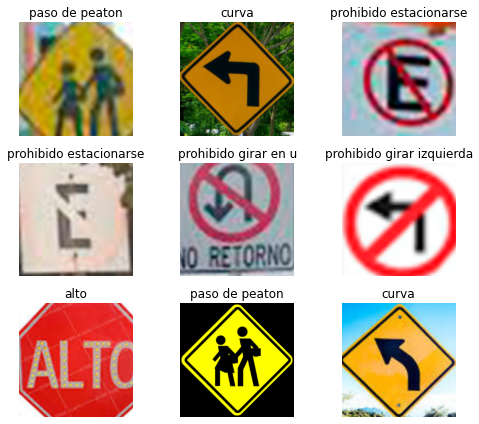

In [ ]:
data.show_batch(rows=3, figsize=(7,6))

Still using the `fastai` library we will apply the transfer learning using Resnet152 and our dataset. We will train this model for 15 epochs using accuracy as our metric.

In [ ]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy)
learn.fit_one_cycle(20)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth


After training our model we can see that it reaches a **maximum validation accuracy of 80% mapped to a 0.6 loss**. 

In [ ]:
# Our model is saved in the same folder as the TrafficSignNet .pth file (link in the sections above)

learn.save('/content/drive/My Drive/Deep Learning/Project/results/transferLearningModel')

Here we can interpret de model using again the `fastai` library. We can see the image, the model's prediction, the ground truth, the loss for the prediction and the probability for the prediction of belonging to the actual class. The library plots the predictions with the highest loss values.

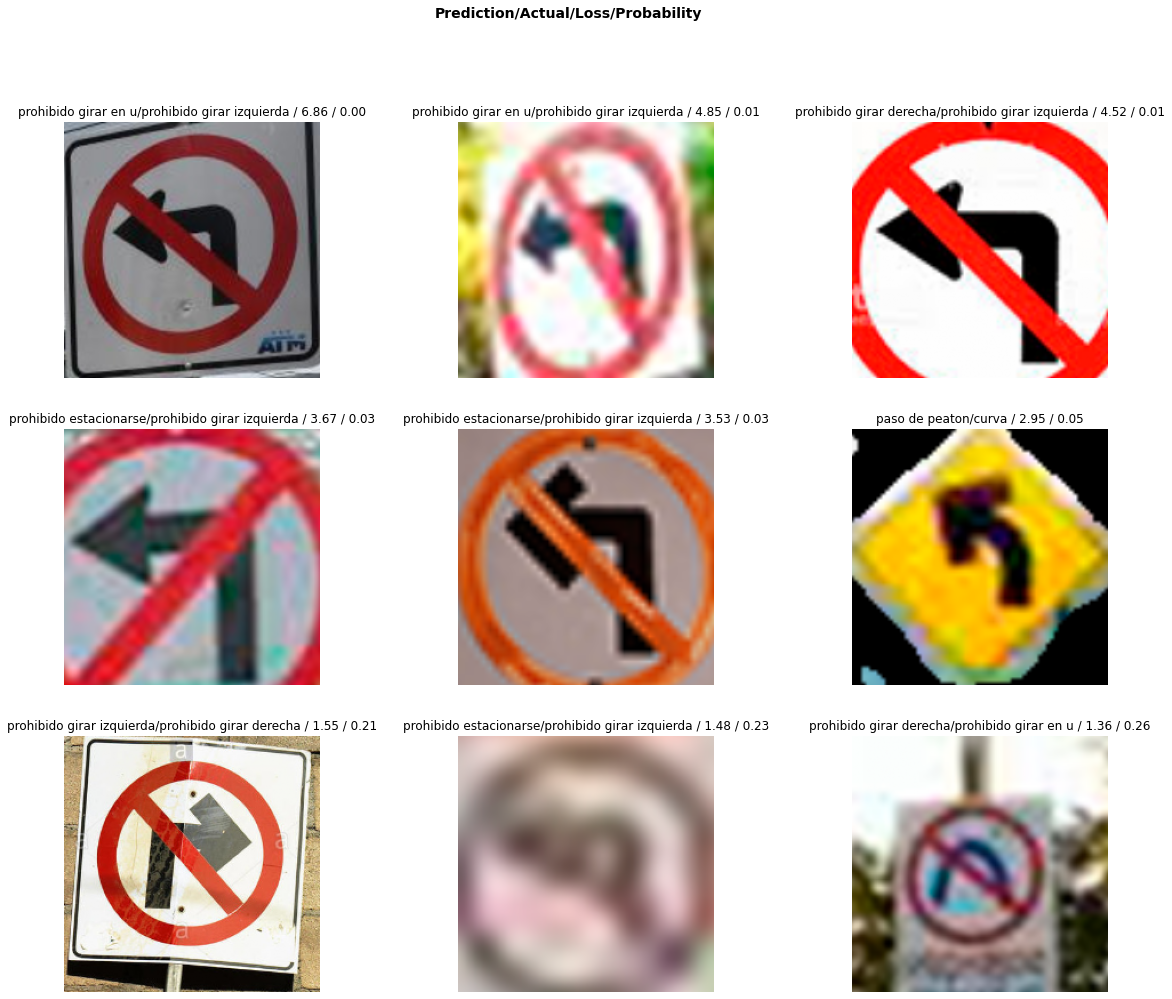

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(20,16))

Sometimes to interpret the model it is easier to construct a confusion matrix. The `fastai` library helps with this and we can observe how the turn right/left, u turn and do not park signs are fairly similar visually and the model indeed gets confused a bit by those classes.

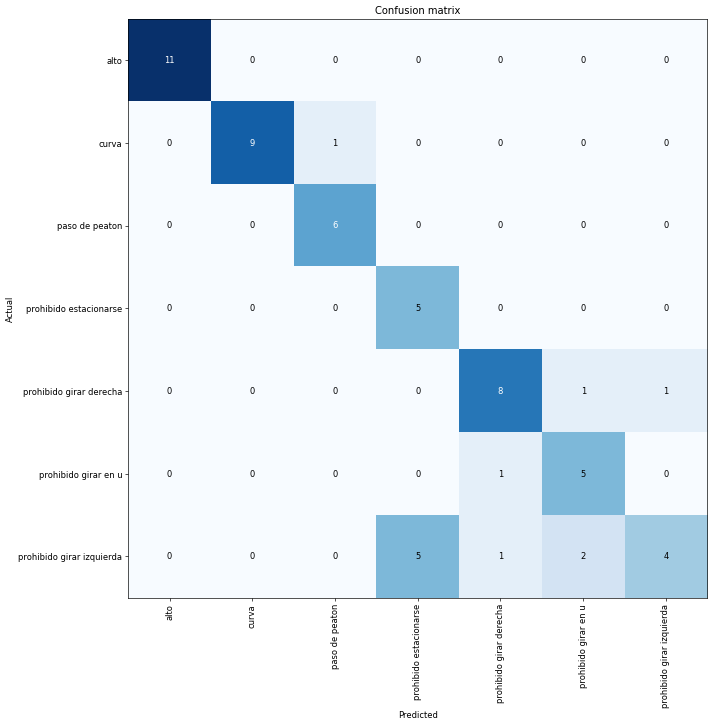

In [ ]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

Now let's test our model with our test dataset.

In [ ]:
test_path = '/content/drive/My Drive/Deep Learning/Project/mx_dataset_final/test_images'
test_images = ImageList.from_folder(test_path)

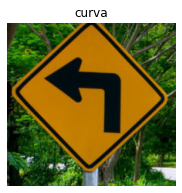

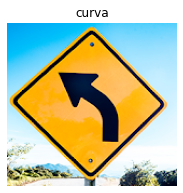

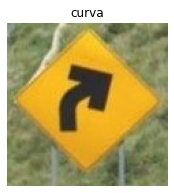

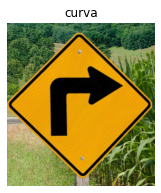

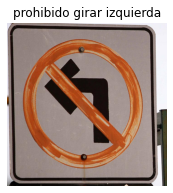

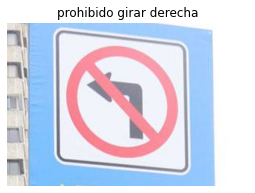

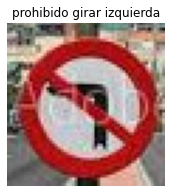

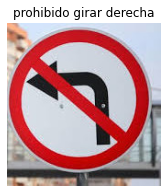

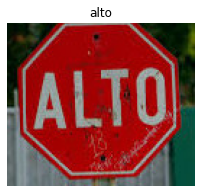

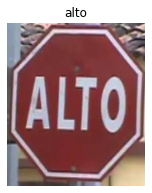

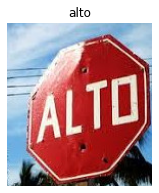

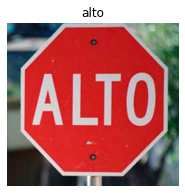

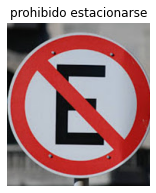

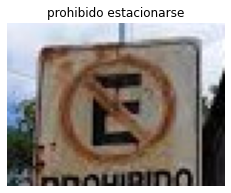

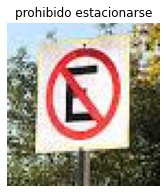

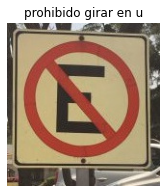

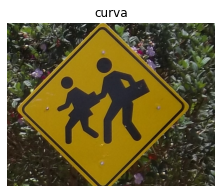

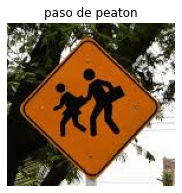

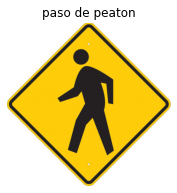

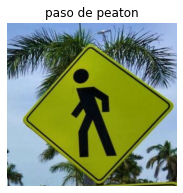

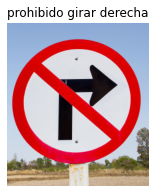

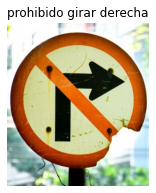

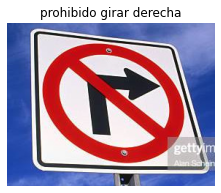

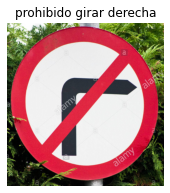

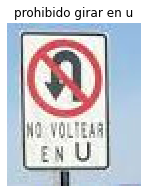

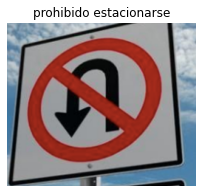

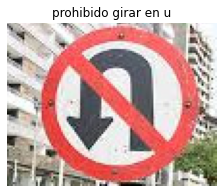

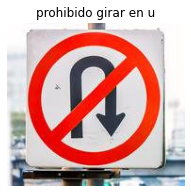

In [ ]:
for img in test_images:
  prediction = learn.predict(img)
  img.show(figsize=(5,3), title = str(prediction[0]))

We can observe that the model works really well with the Mexican traffic signs dataset, specially compared to the one we created (for the German dataset). As we mentioned above, the model gets confused with some pretty visually similar classes.  

###10. Conclusions

The main purpose of our project was to implement data augmentation and our own CNN in order to classify German traffic signs. After we were done with that we decided to test our own dataset of Mexican traffic signs with said model. The results were not favorable at all mainly because of the shape and color differences of the matching signs of both countries.

We decided to fix this problem by using transfer learning and the `fastai` library. We used a pretrained restnet152 model to train our dataset with 300+ images and 7 classes. We were able to reach a maximum **80% accuracy** and got pretty good results on the testing. We realized that our model still got confused with the similar signs such as the *do not turn right/left, do not park and no u-turn*. This is no surprise because the shapes and colors are really similar. 

We concluded that in order to raise our accuracy we need to expand our dataset to at least 80 images per class instead of our actual 40 images per class. This is tedious and long work for which we need more time to accomplish but we are optimistic of the future results if we make these said changes. 